# **Configurações Iniciais e Importação de Bibliotecas.**


In [88]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [89]:
# Caminho para a pasta do banco de dados
pasta = '/content/drive/MyDrive/Desafio Praso/'


In [90]:
!pip install catboost xgboost optuna

In [91]:
import os
# Manipulação de dados
import pandas as pd
import numpy as np
#Visualização de dados
from matplotlib import pyplot as plt
import seaborn as sns
#Pré-processamento de dados
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, LabelEncoder, OrdinalEncoder , TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.pipeline import Pipeline, make_pipeline
#Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
import xgboost as xgb
#Métricas de validação
from sklearn.metrics import roc_auc_score, make_scorer,RocCurveDisplay
#Otimização
import optuna

In [92]:
df = pd.read_csv('/content/drive/MyDrive/Desafio Praso/data/amostra_praso.csv')


---
#**Limpeza e Exploração de Dados**
---


In [93]:
df.head()

,uf,municipio,segmento_cliente,natureza_juridica,fonte_cliente,cnae_codigo,cnae_descricao,capital_social,idade_cnpj,serasa_contagem_negativacoes,serasa_contagem_protestos,serasa_idade_divida_mais_recente,serasa_credores,serasa_socio_tem_negativacao,ifood_contagem_avaliacoes,ifood_faixa_preco,google_maps_avaliacao,google_maps_contagem_avaliacoes,google_maps_tem_website,inadimplente
0,PE,RECIFE,Restaurante Brasileiro,213-5 - Empresário (Individual),Fonte 5,56.11-2-01,Restaurantes e similares,"(8000, 10000]","(50, 100]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1
1,PE,CHA GRANDE,Pizza & Massas,213-5 - Empresário (Individual),Fonte 2,56.11-2-01,Restaurantes e similares,"(3000, 5000]","(750, 900]",0,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,1
2,PB,JOAO PESSOA,Doces & Confeitaria,213-5 - Empresário (Individual),Fonte 2,10.93-7-01,Fabricação de produtos derivados do cacau e de...,"(200, 1000]","(150, 250]",0,0,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,0
3,CE,CASCAVEL,Lanches & Salgados,213-5 - Empresário (Individual),Fonte 2,56.20-1-04,Fornecimento de alimentos preparados preponder...,"(1000, 1500]","(100, 150]",0,0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,1
4,PE,RECIFE,Mercearia & Mercado,213-5 - Empresário (Individual),Fonte 2,56.11-2-03,"Lanchonetes, casas de chá, de sucos e similares","(200, 1000]","(1600, 2000]",1,0,47.0,Bancos e Financeiro,0,NaN,NaN,NaN,NaN,NaN,0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12458 entries, 0 to 12457
Data columns (total 20 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   uf                                12458 non-null  object 
 1   municipio                         12458 non-null  object 
 2   segmento_cliente                  12458 non-null  object 
 3   natureza_juridica                 12458 non-null  object 
 4   fonte_cliente                     12458 non-null  object 
 5   cnae_codigo                       12458 non-null  object 
 6   cnae_descricao                    12458 non-null  object 
 7   capital_social                    12458 non-null  object 
 8   idade_cnpj                        12458 non-null  object 
 9   serasa_contagem_negativacoes      12458 non-null  int64  
 10  serasa_contagem_protestos         12458 non-null  int64  
 11  serasa_idade_divida_mais_recente  2356 non-null   float64
 12  sera

## Percentual de valores nulos

In [95]:
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False).round(2)

,0
ifood_contagem_avaliacoes,96.15
ifood_faixa_preco,93.14
google_maps_avaliacao,93.06
google_maps_tem_website,91.67
google_maps_contagem_avaliacoes,91.67
serasa_credores,84.15
serasa_idade_divida_mais_recente,81.09
uf,0.00
municipio,0.00
serasa_socio_tem_negativacao,0.00


## Contagem de Classes por Feature

In [96]:
df.nunique().sort_values(ascending=False)

,0
serasa_credores,397
cnae_codigo,352
cnae_descricao,352
municipio,165
serasa_idade_divida_mais_recente,60
serasa_contagem_negativacoes,59
serasa_contagem_protestos,56
segmento_cliente,21
idade_cnpj,20
capital_social,19


## Estatística geral

In [97]:
df.describe().round(2)

,serasa_contagem_negativacoes,serasa_contagem_protestos,serasa_idade_divida_mais_recente,serasa_socio_tem_negativacao,google_maps_tem_website,inadimplente
count,12458.00,12458.00,2356.00,12458.00,1038.0,12458.00
mean,0.94,1.03,14.54,0.48,1.0,0.41
std,11.04,62.84,14.17,0.50,0.0,0.49
min,0.00,0.00,1.00,0.00,1.0,0.00
25%,0.00,0.00,3.00,0.00,1.0,0.00
50%,0.00,0.00,9.00,0.00,1.0,0.00
75%,0.00,0.00,21.00,1.00,1.0,1.00
max,912.00,6917.00,60.00,1.00,1.0,1.00


## **Exploração CNAE**


In [98]:
df_copy = df[['cnae_codigo']].copy()
df_copy['cnae_codigo'].nunique()


352

In [99]:
def separar_cnae(cnae_codigo):
    partes = cnae_codigo.split('-')
    divisao = partes[0].split('.')[0]  # Primeiros 2 dígitos
    grupo = '.'.join(partes[0].split('.')[:2])  # Primeiros 4 dígitos
    classe = f"{partes[0]}-{partes[1]}"  # Código antes do último hífen

    return divisao, grupo, classe


df_copy[['divisao', 'grupo', 'classe']] = df_copy['cnae_codigo'].apply(lambda x: pd.Series(separar_cnae(x)))
df_copy[['divisao', 'grupo', 'classe']].nunique()

,0
divisao,57
grupo,230
classe,230


In [100]:
df_copy['divisao'].unique()

array(['56', '10', '49', '31', '85', '47', '61', '95', '43', '96', '55',
       '63', '33', '45', '86', '58', '81', '64', '53', '77', '52', '46',
       '14', '32', '25', '82', '71', '73', '87', '79', '70', '41', '69',
       '03', '93', '62', '90', '17', '29', '18', '13', '97', '74', '23',
       '68', '50', '16', '01', '35', '22', '42', '59', '75', '66', '38',
       '80', '15'], dtype=object)

In [101]:
cnae_divisoes = {
    '01': 'Agricultura, Pecuária e Serviços Relacionados',
    '03': 'Pesca e Aquicultura',
    '10': 'Fabricação de Produtos Alimentícios',
    '13': 'Fabricação de Produtos Têxteis',
    '14': 'Confecção de Artigos do Vestuário e Acessórios',
    '15': 'Preparação de Couros e Fabricação de Artefatos de Couro, Artigos para Viagem e Calçados',
    '16': 'Fabricação de Produtos de Madeira',
    '17': 'Fabricação de Celulose, Papel e Produtos de Papel',
    '18': 'Impressão e Reprodução de Gravações',
    '22': 'Fabricação de Produtos de Borracha e de Material Plástico',
    '23': 'Fabricação de Produtos de Minerais Não-Metálicos',
    '25': 'Fabricação de Produtos de Metal, Exceto Máquinas e Equipamentos',
    '29': 'Fabricação de Veículos Automotores, Reboques e Carrocerias',
    '31': 'Fabricação de Móveis',
    '32': 'Fabricação de Produtos Diversos',
    '33': 'Manutenção, Reparação e Instalação de Máquinas e Equipamentos',
    '35': 'Eletricidade, Gás e Outras Utilidades',
    '38': 'Coleta, Tratamento e Disposição de Resíduos; Recuperação de Materiais',
    '41': 'Construção de Edifícios',
    '42': 'Obras de Infraestrutura',
    '43': 'Serviços Especializados para Construção',
    '45': 'Comércio e Reparação de Veículos Automotores e Motocicletas',
    '46': 'Comércio por Atacado, Exceto Veículos Automotores e Motocicletas',
    '47': 'Comércio Varejista',
    '49': 'Transporte Terrestre',
    '50': 'Transporte Aquaviário',
    '52': 'Armazenagem e Atividades Auxiliares aos Transportes',
    '53': 'Correio e Outras Atividades de Entrega',
    '55': 'Alojamento',
    '56': 'Alimentação',
    '58': 'Edição',
    '59': 'ATIVIDADES CINEMATOGRÁFICAS, PRODUÇÃO DE VÍDEOS E DE PROGRAMAS DE TELEVISÃO; GRAVAÇÃO DE SOM E EDIÇÃO DE MÚSICA',
    '61': 'Telecomunicações',
    '62': 'Atividades dos Serviços de Tecnologia da Informação',
    '63': 'Atividades de Prestação de Serviços de Informação',
    '64': 'Atividades de Serviços Financeiros',
    '66': 'Atividades de Serviços Relacionados com Seguros e Previdência Complementar',
    '68': 'Atividades Imobiliárias',
    '69': 'Atividades Jurídicas, de Contabilidade e de Auditoria',
    '70': 'Atividades de Sedes de Empresas e de Consultoria em Gestão Empresarial',
    '71': 'Atividades de Arquitetura e Engenharia',
    '73': 'Publicidade e Pesquisa de Mercado',
    '74': 'Outras Atividades Profissionais, Científicas e Técnicas',
    '75': 'Atividades Veterinárias',
    '77': 'Aluguel de Bens Móveis e Gestão de Ativos Intangíveis Não-Financeiros',
    '79': 'Agências de Viagens, Operadores Turísticos e Serviços de Reservas',
    '80': 'Atividades de Segurança e Investigação',
    '81': 'Serviços para Edifícios e Atividades Paisagísticas',
    '82': 'Serviços Administrativos e Complementares',
    '85': 'Educação',
    '86': 'Atividades de Atenção à Saúde Humana',
    '87': 'Atividades de Atenção à Saúde Humana Integrada',
    '90': 'Atividades Artísticas, Criativas e de Espetáculos',
    '93': 'Atividades Esportivas e de Recreação e Lazer',
    '95': 'Reparação e Manutenção de Equipamentos e Produtos de Uso Pessoal e Doméstico',
    '96': 'Outras Atividades de Serviços Pessoais',
    '97': 'Serviços Domésticos'
}



## **Exploração municipio**



In [102]:
df['municipio'].unique()

array(['RECIFE', 'CHA GRANDE', 'JOAO PESSOA', 'CASCAVEL', 'ABREU E LIMA',
       'ARACOIABA', 'IPOJUCA', 'CAUCAIA', 'CHA DE ALEGRIA', 'PARACURU',
       'FORTALEZA', 'CARUARU', 'CONDE', 'PAULISTA', 'PACATUBA',
       'VITORIA DE SANTO ANTAO', 'CAMARAGIBE', 'CABO DE SANTO AGOSTINHO',
       'OLINDA', 'SAO LOURENCO DA MATA', 'PARAIPABA', 'CORTES', 'EUSEBIO',
       'GRAVATA', 'MARANGUAPE', 'HORIZONTE', 'JABOATAO DOS GUARARAPES',
       'ILHA DE ITAMARACA', 'QUEIMADAS', 'BARREIRA', 'MARACANAU',
       'AQUIRAZ', 'GUAIUBA', 'ACARAPE', 'TAMANDARE', 'BEZERROS',
       'CABEDELO', 'PINDORETAMA', 'SANTA RITA', 'ITAITINGA',
       'FERNANDO DE NORONHA', 'MORENO', 'PACAJUS', 'SIRINHAEM', 'SOBRAL',
       'BATURITE', 'CARPINA', 'MACEIO', 'BARREIROS',
       'SAO GONCALO DO AMARANTE', 'IGARASSU', 'UBAJARA', 'POMBOS',
       'BAYEUX', 'GUARAMIRANGA', 'CARIDADE', 'CANINDE', 'RIO FORMOSO',
       'GLORIA DO GOITA', 'CHOROZINHO', 'ARCOVERDE', 'BUIQUE', 'REDENCAO',
       'JIJOCA DE JERICOACOARA', 'LAG

In [103]:
capitais = ['RECIFE', 'JOAO PESSOA', 'FORTALEZA', 'MACEIO']

regiao_metropolitana_recife = ['OLINDA', 'JABOATAO DOS GUARARAPES', 'CAMARAGIBE', 'ABREU E LIMA', 'PAULISTA',
                               'ILHA DE ITAMARACA', 'IGARASSU', 'MORENO', 'IPOJUCA', 'SAO LOURENCO DA MATA',
                               'ITAPISSUMA', 'CABO DE SANTO AGOSTINHO']

regiao_metropolitana_joao_pessoa = ['CABEDELO', 'BAYEUX', 'SANTA RITA', 'ALHANDRA', 'LUCENA']

regiao_metropolitana_fortaleza = ['CAUCAIA', 'MARACANAU', 'MARANGUAPE', 'EUSEBIO', 'PACATUBA', 'ITAITINGA',
                                  'HORIZONTE', 'AQUIRAZ', 'PACAJUS', 'PINDORETAMA']

regiao_metropolitana_maceio = ['RIO LARGO', 'MARECHAL DEODORO', 'SATUBA']

def classificar_municipio(municipio):

    if municipio in capitais:
        return 'Capital'
    elif municipio in regiao_metropolitana_recife + regiao_metropolitana_joao_pessoa + \
         regiao_metropolitana_fortaleza + regiao_metropolitana_maceio:
        return 'Região Metropolitana'
    else:
        return 'Interior'



## **Aplicação da Função de Processamento**

### 1️⃣ Conversão de Intervalos em Valores Contínuos  
- Transformação de colunas que contêm intervalos em valores contínuos, utilizando o **ponto máximo** ou o **ponto médio** do intervalo.  

### 2️⃣ Tratamento de Valores Nulos  
- Identificação de colunas com mais de **80% de valores ausentes**:  
  - `ifood_contagem_avaliacoes`  
  - `ifood_faixa_preco`  
  - `google_maps_avaliacao`  
  - `google_maps_tem_website`  
  - `google_maps_contagem_avaliacoes`  
  - `serasa_credores`  
  - `serasa_idade_divida_mais_recente`  

### 3️⃣ Engenharia de Atributos – Criação de Novas Colunas  
- **`has_ifood`**: Indica se a empresa está cadastrada no **iFood** (`1` para "sim", `0` para "não").  
- **`has_google_maps`**: Indica se a empresa possui presença no **Google Maps** (`1` para "sim", `0` para "não").  
- **`has_website`**: Indica se há um website vinculado ao perfil no **Google Maps** (`"Tem Website"` ou `"Não Tem Website"`).  
- **`ifood_preco`**: Categorização da faixa de preço do **iFood** em cinco níveis:  
  - `"Barato"`  
  - `"Moderado"`  
  - `"Caro"`  
  - `"Muito caro"`  
  - `"Muito muito caro"`  
- **`capital_social`**: Normalização do capital social utilizando escala **logarítmica** (`log2(x + 1)`).  
- **`idade_cnpj`**: Conversão da idade do CNPJ para **anos** e categorização:  
  - `"Muito novo"` (≤ 1 ano)  
  - `"Novo"` (≤ 4 anos)  
  - `"Moderado"` (< 10 anos)  
  - `"Antigo"` (≥ 10 anos)  
- **`perfil_risco`**: Classificação do perfil de risco com base em **negativações** e **protestos** no Serasa:  
  - `"Baixo"`: Nenhuma negativação ou protesto.  
  - `"Médio"`: Algumas ocorrências.  
  - `"Alto"`: Mais de 5 negativações ou protestos.  
- **`deve_outra_empresa`**: Variável binária indicando se a empresa possui **dívidas registradas** com outra instituição (`1` para "sim", `0` para "não").  
- **`numero_credores`**: Contagem do número de **credores associados** à empresa, a partir dos registros do **Serasa**.  

### 4️⃣ Categorização de Municípios  
- Classificação dos municípios em **categorias** para análise geográfica estruturada.  

### 5️⃣ Redução de Cardinalidade  
- **`cnae_divisao`**: Agrupamento dos setores econômicos com base em divisões do **CNAE**.  
- **`categoria_municipio`**: Redução da cardinalidade da variável de **município**, baseada em uma categorização pré-definida.  


In [104]:
def data_cleaning_and_transform(df):
    """
    Função para limpar e transformar um DataFrame conforme as etapas especificadas.
    """

    def max_interval(interval):
        """Transformando os intervalos em valores contínuos, extraindo o ponto máximo do intervalo."""
        if pd.notnull(interval):
                numbers = pd.Series(interval).str.extract(r'\((\d+),\s*(\d+)\]').astype(int)

                return max(numbers[0][0], numbers[1][0])
        else:
            return np.nan



    def midpoint(interval):

        """ Transformando as colunas de intervalos em valores contínuos
        extraindo o ponto médio do intervalo """

        numbers = interval.str.extract(r'\((\d+),\s*(\d+)\]').astype(float)
        midpoint = (numbers[0] + numbers[1]) / 2
        return  midpoint



    #Tranforma o intervalo em
    df['capital_social'] = midpoint(df['capital_social'])
    df['idade_cnpj'] = midpoint(df['idade_cnpj'])

    #extrai o intervalo
    df['ifood_contagem_avaliacoes'] = df['ifood_contagem_avaliacoes'].apply(max_interval)
    df['google_maps_contagem_avaliacoes'] = df['google_maps_contagem_avaliacoes'].apply(max_interval)




    #Novas features
    #colunas binarias
    df['has_ifood'] = df['ifood_contagem_avaliacoes'].apply(lambda x: 1 if pd.notnull(x) else 0)
    df['has_google_maps'] = df['google_maps_contagem_avaliacoes'].apply(lambda x: 1 if pd.notnull(x) else 0)

    #coluna_website
    df['has_website'] = df['google_maps_tem_website'].map({
        1: 'Tem Website'
    }).fillna('Nao tem Website')

    # coluna ifood_preco
    df['ifood_preco'] = df['ifood_faixa_preco'].map({
        '$': 'Barato',
        '$$': 'Moderado',
        '$$$': 'Caro',
        '$$$$': 'Muito caro',
        '$$$$$': 'Muito muito caro'
    }).fillna('Não listado no iFood')


    #Normalização do capital, mantem a hierarquia de ordem
    df['capital_social'] = df['capital_social'].apply(lambda x: np.log2(x+1))

    # converter para anos e cria um nova coluna categorica
    df['idade_cnpj'] = (df['idade_cnpj'] / 365).astype(float).round(2)
    df['cnpj_categoria'] = df['idade_cnpj'].apply(lambda x: "Muito novo" if x <= 1 else
                                                            "Novo" if x <= 4 else
                                                            "Moderado" if x < 10 else
                                                            "Antigo")


    #Classificação do perfil de risco com base nas negativacoes e protestos
    df['perfil_risco'] = df.apply(
        lambda row: 'Baixo' if (row['serasa_contagem_negativacoes'] == 0 and row['serasa_contagem_protestos'] == 0)
        else 'Alto' if (row['serasa_contagem_negativacoes'] > 5 or row['serasa_contagem_protestos'] > 5)
        else 'Médio', axis=1
    )


    # Verifica se a empresa possui dívida registrada
    df['deve_outra_empresa'] = df['serasa_idade_divida_mais_recente'].apply(lambda x: 1 if pd.notnull(x) else 0)

    # Conta o número de credores da empresa
    df['numero_credores'] = df['serasa_credores'].apply(lambda x: len(str(x).split(',')) if pd.notnull(x) else 0)



    #Redução de cardinalidade da coluna cnae
    df['cnae_divisao'] = df_copy['divisao'].map(cnae_divisoes)

    # Redução de cardinalidade da fature municipio
    df['categoria_municipio'] = df['municipio'].apply(classificar_municipio)

    return df



In [105]:
df = data_cleaning_and_transform(df)

## Verifica os valores das novas colunas


In [106]:
df['has_google_maps'].unique(), df['has_ifood'].unique(), df['has_website'].unique(), df['ifood_preco'].unique(), df['cnpj_categoria'].unique(), df['perfil_risco'].unique()


(array([0, 1]),
 array([0, 1]),
 array(['Nao tem Website', 'Tem Website'], dtype=object),
 array(['Não listado no iFood', 'Barato', 'Muito muito caro', 'Caro',
        'Moderado', 'Muito caro'], dtype=object),
 array(['Muito novo', 'Novo', 'Moderado', 'Antigo'], dtype=object),
 array(['Baixo', 'Médio', 'Alto'], dtype=object))

In [107]:
print("\n ", df['deve_outra_empresa'].value_counts(), "\n ")
print( df['numero_credores'].value_counts())



  deve_outra_empresa
0    10102
1     2356
Name: count, dtype: int64 
 
numero_credores
0    10483
1     1332
2      366
3      172
4       61
5       25
6       10
7        4
8        4
9        1
Name: count, dtype: int64


In [108]:
print(df[['municipio','categoria_municipio']].head())
print("\n", "Classes da nova coluna: " , df['categoria_municipio'].unique())


     municipio categoria_municipio
0       RECIFE             Capital
1   CHA GRANDE            Interior
2  JOAO PESSOA             Capital
3     CASCAVEL            Interior
4       RECIFE             Capital

 Classes da nova coluna:  ['Capital' 'Interior' 'Região Metropolitana']


## Exploração e visualização de outliers

In [109]:
#Numero de outliers por colunas numericas nao binarias
numerics = ['idade_cnpj', 'capital_social', 'serasa_contagem_negativacoes', 'serasa_contagem_protestos', 'numero_credores']

for col in numerics:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    if IQR == 0:
        lower_bound = 0
        upper_bound = 0
    else:
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"Numero e proporção de outliers em {col}: {len(outliers)} -- {len(outliers) / len(df) * 100:.2f}%" ,f"limites : {lower_bound} e {upper_bound}")

Numero e proporção de outliers em idade_cnpj: 807 -- 6.48% limites : -7.670000000000001 e 14.25
Numero e proporção de outliers em capital_social: 839 -- 6.73% limites : 5.792183812631376 e 19.076929294770526
Numero e proporção de outliers em serasa_contagem_negativacoes: 2050 -- 16.46% limites : 0 e 0
Numero e proporção de outliers em serasa_contagem_protestos: 839 -- 6.73% limites : 0 e 0
Numero e proporção de outliers em numero_credores: 1975 -- 15.85% limites : 0 e 0


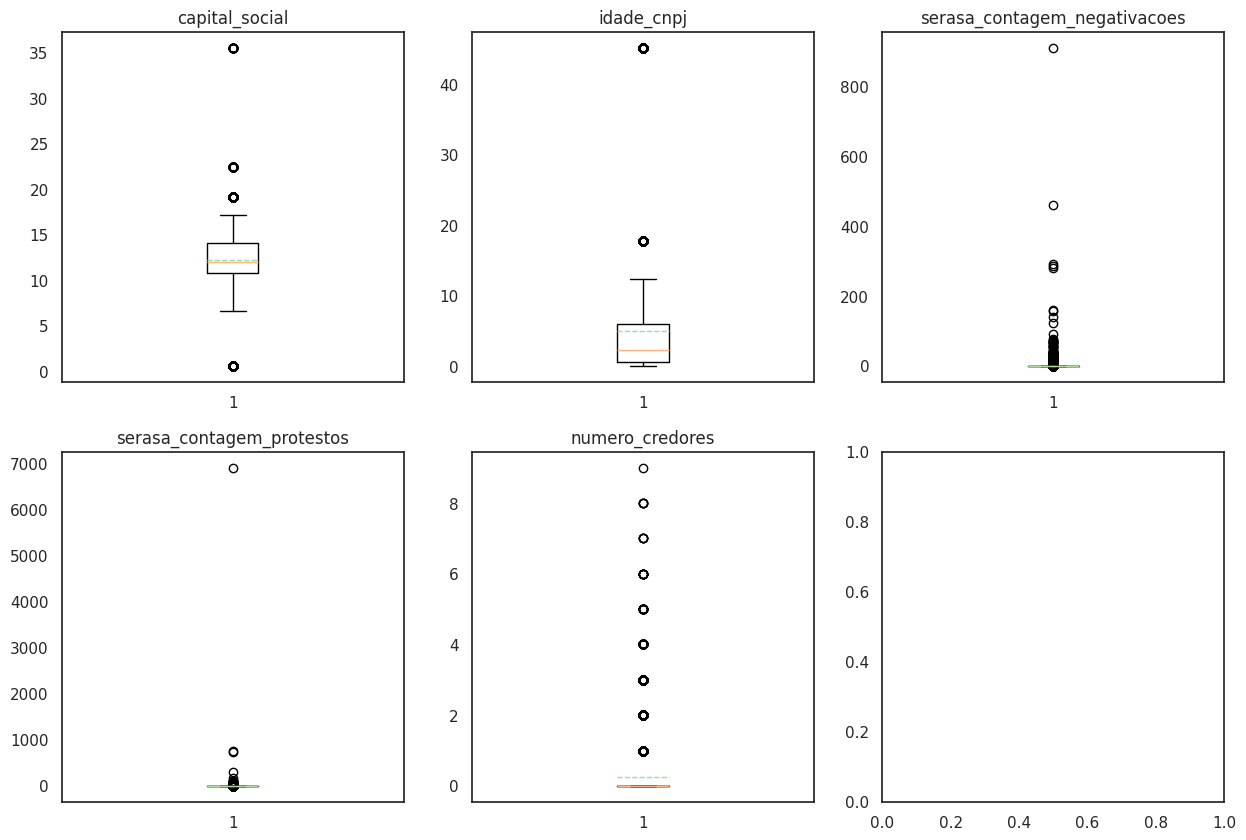

In [110]:
def plot_boxplot(data, numerics):
  qtd = len(numerics)
  figure = plt.figure(figsize = (3*qtd, 2*qtd))
  linha, altura = (np.ceil(qtd/3), 3)
  figure.subplots(int(linha), int(altura))

  for (i, values) in enumerate(numerics):
    plt.subplot(linha, altura, i+1)
    plt.boxplot(data[values], meanline = True ,showmeans=True)
    plt.title(values)


numerics = ["capital_social", "idade_cnpj", "serasa_contagem_negativacoes", "serasa_contagem_protestos", "numero_credores"]
plot_boxplot(df, numerics)

## **Descarte de Colunas Não Utilizáveis**

In [111]:
df = df.drop(columns=['ifood_contagem_avaliacoes','ifood_faixa_preco', 'google_maps_contagem_avaliacoes','google_maps_tem_website','google_maps_avaliacao', 'serasa_credores',
                      'serasa_idade_divida_mais_recente', 'cnae_codigo','municipio',
                      'serasa_contagem_negativacoes', 'serasa_contagem_protestos', 'idade_cnpj'])

-----------
# **Visualização de Dados**
-----------

## **Análise da Quantidade de clientes pagantes/não pagantes**



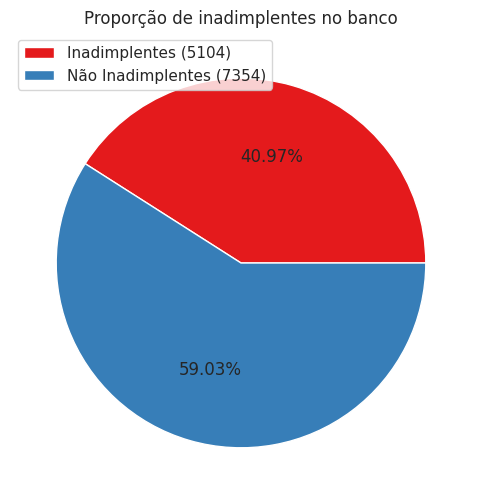

In [83]:
def print_pie_inadimplente(data):
  inadimplentes = data["inadimplente"].values

  #Conta quantos clientes estão em cada situação, considerando que o fato que essa coluna é não nula
  V = np.sum(inadimplentes == 1)
  F = np.sum(inadimplentes == 0)
  colors = sns.color_palette('Set1')

  plt.figure(figsize=(10,6))
  plt.pie([V,F],colors= colors, autopct = "%0.2f%%")
  plt.legend(["Inadimplentes" + f" ({V})", "Não Inadimplentes" + f" ({F})"], loc = "upper left")
  plt.title("Proporção de inadimplentes no banco")
  plt.show()

print_pie_inadimplente(df)

## **Análise da Relação inadimplência e Categoria Município**






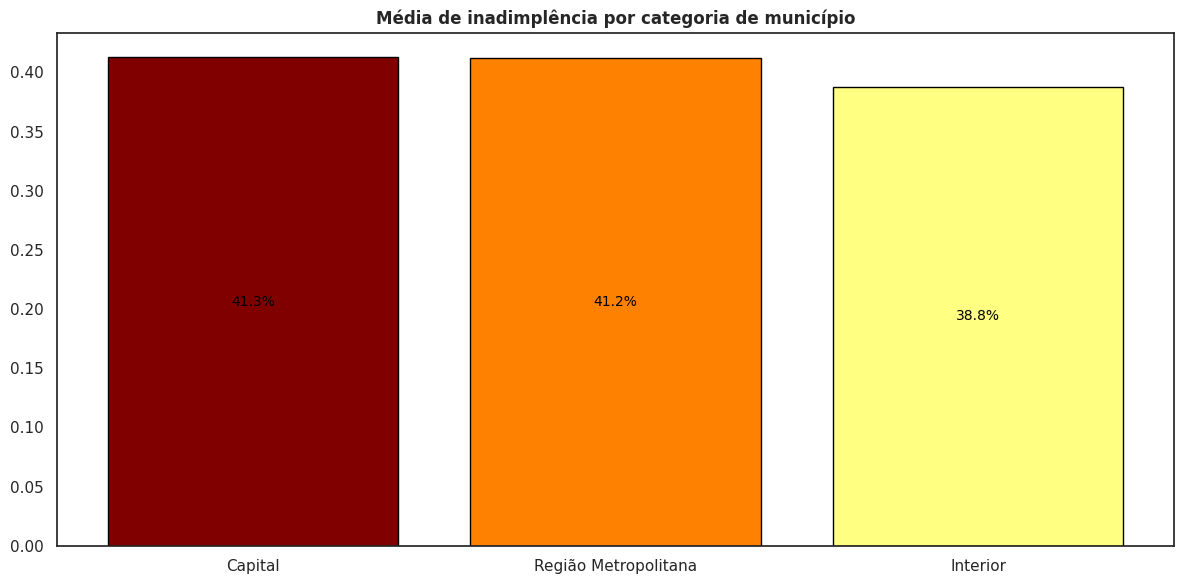

In [84]:
#define o plot
def plot_inadimplencia_por_categoria_municipio(data):
  fig, ax = plt.subplots(figsize=(12, 6))
  grouped = data.groupby('categoria_municipio').inadimplente.mean().sort_values(ascending=False)
  colors = sns.color_palette('afmhot', 3)

  bars = ax.bar(grouped.index, grouped.values, color = colors, edgecolor = 'black')


  #define a visualização das porcentagens
  for bar in bars:
      height = bar.get_height()
      percentage = height * 100
      ax.text(bar.get_x() + bar.get_width() / 2, height / 2, f'{percentage:.1f}%',
              ha='center', va='center', fontsize=10, color='black')


  # estilização do plot
  ax.grid(False)
  ax.set_xlabel('')
  ax.set_xticks(range(len(grouped)))
  ax.set_xticklabels(grouped.index)
  ax.tick_params(color='grey')
  ax.set_title('Média de inadimplência por categoria de município', fontweight ='bold')
  plt.tight_layout()

plot_inadimplencia_por_categoria_municipio(df)

## **Análise de Inadimplência por Segmento e UF**

In [77]:
def print_nome_segmento(data):
  segmentos = data["segmento_cliente"].copy().values

  grouped = data.groupby("segmento_cliente")

  #Todos as possíbilidades de segmentos no CSV, retorna quantidade de cada
  segmentos_registrados, distribuicao = np.unique(segmentos, return_counts = True)

  #Formatacao do print
  maior_nome_segmento = np.max([len(s) for s in segmentos_registrados])

  #Cria saidas identadas
  label = "Name" + (maior_nome_segmento - len("Name"))*" " + "|" + " Instancias"
  line = len(label)*"-"
  segmentos_registrados = [elemento + (maior_nome_segmento - len(elemento))*" " for elemento in segmentos_registrados]


  #Apenas configurando o print!
  print(label)
  print(line)
  for (i,element) in enumerate(segmentos_registrados):
    print(f"{element}| {distribuicao[i]}", flush = True)

  print(line)
  print(f"Total{(maior_nome_segmento - len('Total'))*' '}| {np.sum(distribuicao)}")

print_nome_segmento(df)

Name                                                       | Instancias
-----------------------------------------------------------------------
Atacarejo & Supermercado                                   | 237
Açaí & Sorvetes                                            | 210
Bar                                                        | 421
Cafeteria                                                  | 178
Churrascaria                                               | 236
Clube                                                      | 27
Conveniência                                               | 336
Cozinha Industrial                                         | 218
Distribuidor                                               | 342
Doces & Confeitaria                                        | 1645
Hambúrguer                                                 | 459
Hospital                                                   | 11
Hotel                                                      | 171
Japonês & Ch

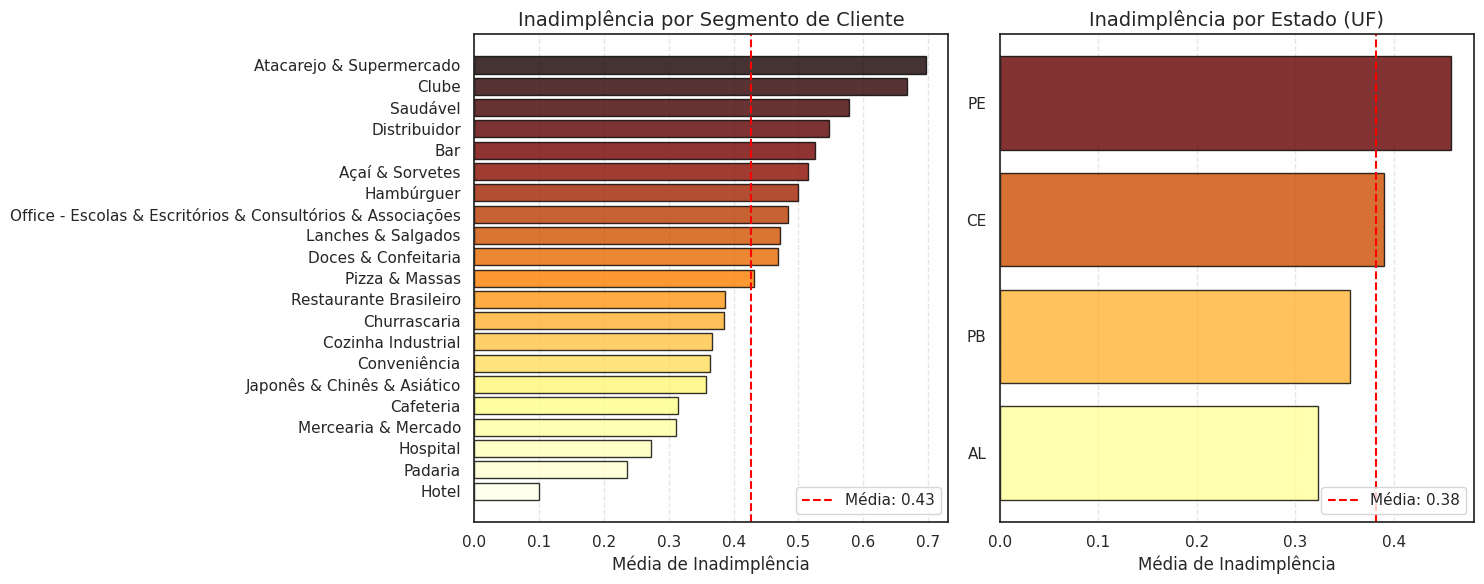

In [85]:
def plot_inadimplencia_por_segmento_cliente(data):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

  # Plot 1: Inadimplência por segmento de cliente
  grouped_segmento = data.groupby('segmento_cliente').inadimplente.mean().sort_values()
  colors = sns.color_palette('afmhot_r', 21)
  bars = ax1.barh(grouped_segmento.index, grouped_segmento, color=colors, edgecolor='black', alpha=0.8)
  ax1.axvline(grouped_segmento.mean(), color='red', linestyle='--', label=f'Média: {grouped_segmento.mean():.2f}')
  ax1.set_title('Inadimplência por Segmento de Cliente', fontsize=14)
  ax1.set_xlabel('Média de Inadimplência')
  ax1.grid(axis='x', linestyle='--', alpha=0.5)
  ax1.legend()

  # Plot 2: Inadimplência por UF
  grouped_uf = data.groupby('uf').inadimplente.mean().sort_values()
  colors = sns.color_palette('afmhot_r', 4)
  bars = ax2.barh(grouped_uf.index, grouped_uf, color=colors, edgecolor='black', alpha=0.8)
  ax2.axvline(grouped_uf.mean(), color='red', linestyle='--', label=f'Média: {grouped_uf.mean():.2f}')
  ax2.set_title('Inadimplência por Estado (UF)', fontsize=14)
  ax2.set_xlabel('Média de Inadimplência')
  ax2.grid(axis='x', linestyle='--', alpha=0.5)
  ax2.legend(loc='lower right')

  plt.tight_layout()
  plt.show()

plot_inadimplencia_por_segmento_cliente(df)

## **Análise da Relação taxa de inadimplência e presença em plataformas**

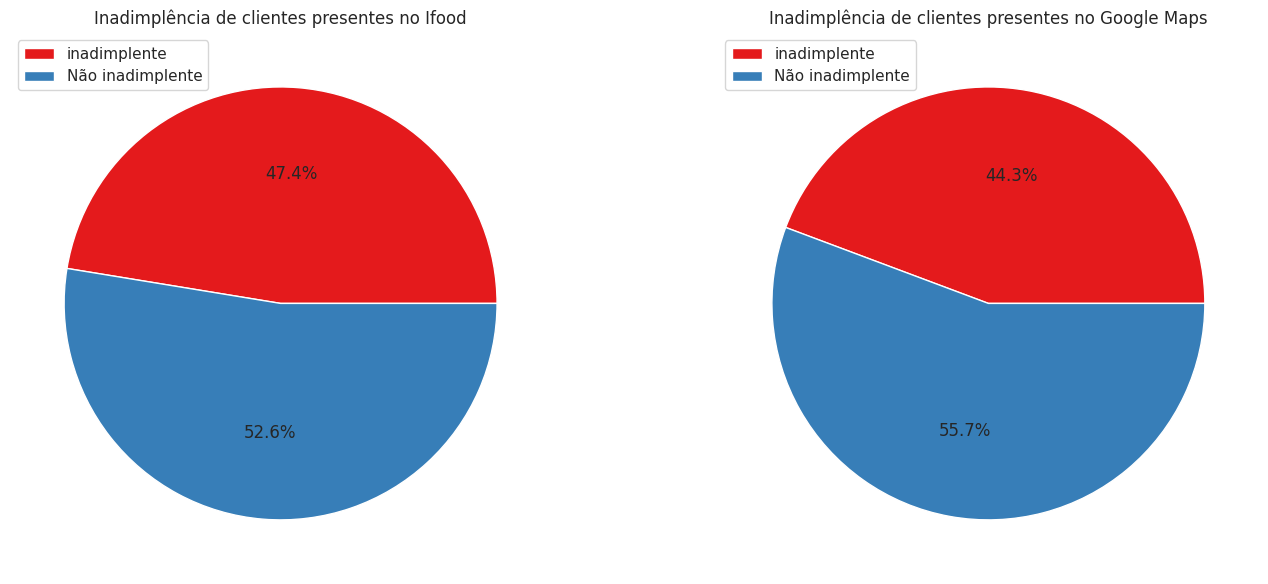

In [86]:
#relacionar inadiplencia e has_ifood / has_google_maps
def plot_inadimplencia_relacionada_a_presenca_em_plataformas(data):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
  colors = sns.color_palette('Set1')
  grouped_ifood = data.groupby('has_ifood').inadimplente.mean().sort_values(ascending = True)
  ax1.pie(grouped_ifood, autopct='%1.1f%%', colors=colors)
  ax1.set_title('Inadimplência de clientes presentes no Ifood')
  ax1.legend(["inadimplente","Não inadimplente"], loc="upper left")

  grouped_google = data.groupby('has_google_maps').inadimplente.mean().sort_values(ascending = True)
  ax2.pie(grouped_google, autopct='%1.1f%%', colors=colors)
  ax2.set_title('Inadimplência de clientes presentes no Google Maps')
  ax2.legend(["inadimplente","Não inadimplente"], loc="upper left")


  plt.tight_layout()
  plt.show()


plot_inadimplencia_relacionada_a_presenca_em_plataformas(df)

## **Análise de inadimplência e socio inadimplente**



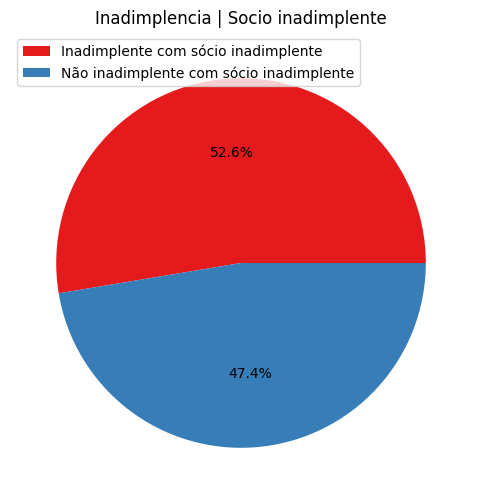

In [52]:
#com a probabilidade de inadimplente (essencial para gerenciar o aprendizado do modelo)
def probabilidade_condicionada_socio_negativado(data):
  data = data.copy()
  prob_list = []
  atributos_serasa = [atributo for atributo in data if "serasa" in atributo ]
  colors = colors = sns.color_palette('Set1')
  inadim_soc, inadim_cli = data["serasa_socio_tem_negativacao"].astype(bool), data["inadimplente"].astype(bool)

  qtd = np.sum
  matriz = np.array([[qtd((inadim_soc & inadim_cli) == True), qtd((~inadim_soc & inadim_cli) == True)], [qtd((inadim_soc & ~inadim_cli) == True), qtd((~inadim_soc & ~inadim_cli) == True)]])
  total = matriz.sum()
  prob = matriz[0, 0] / total  # P(Inadimplente | Sócio inadimplente)
  n_prob = matriz[1, 0] / total  # P(Não Inadimplente | Sócio inadimplente)

  plt.figure(figsize=(10,6))
  plt.pie([prob, n_prob], autopct='%1.1f%%', colors=colors)
  plt.legend(["Inadimplente com sócio inadimplente", "Não inadimplente com sócio inadimplente"], loc="upper left")
  plt.title("Inadimplencia | Socio inadimplente")
  plt.show()

probabilidade_condicionada_socio_negativado(df)

## Análise da Inadimplência por Perfil de Risco e Dívidas com Outras Empresas

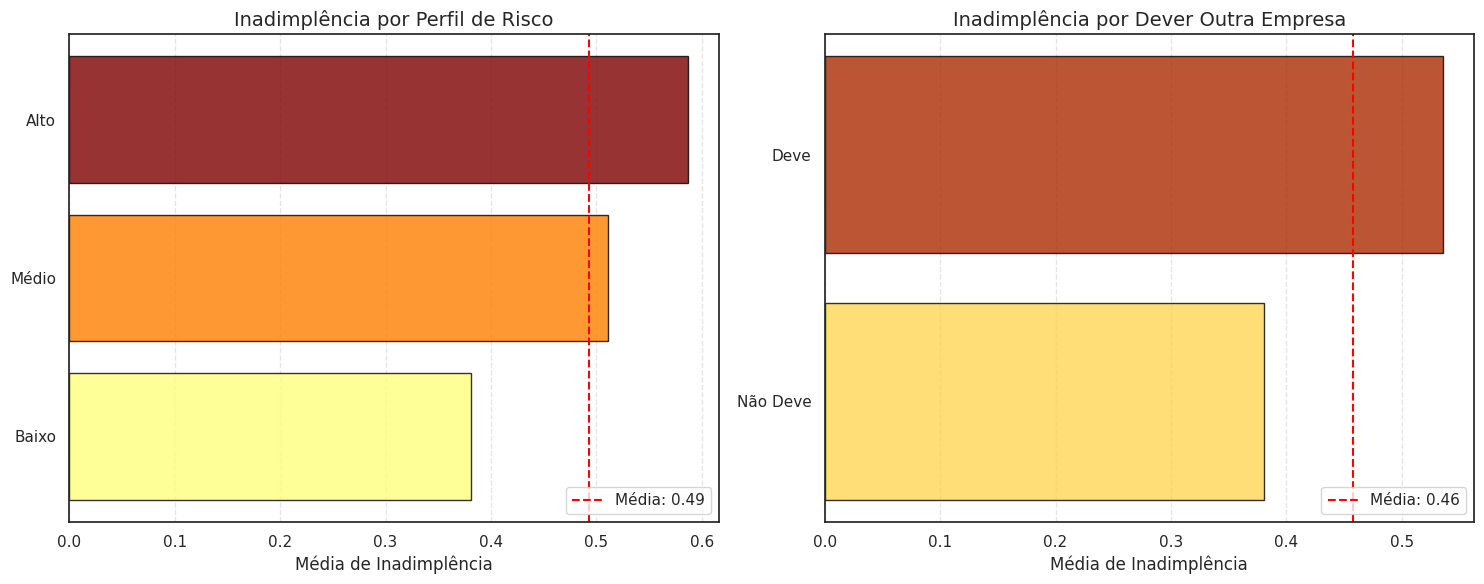

In [82]:
# Supondo que 'df' é o DataFrame original
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Inadimplência por Perfil de Risco
grouped_risco = df.groupby('perfil_risco').inadimplente.mean().sort_values()
colors = sns.color_palette('afmhot_r', 3)
bars = ax1.barh(grouped_risco.index, grouped_risco, color=colors, edgecolor='black', alpha=0.8)
ax1.axvline(grouped_risco.mean(), color='red', linestyle='--', label=f'Média: {grouped_risco.mean():.2f}')
ax1.set_title('Inadimplência por Perfil de Risco', fontsize=14)
ax1.set_xlabel('Média de Inadimplência')
ax1.grid(axis='x', linestyle='--', alpha=0.5)
ax1.legend(loc='lower right')

# Plot 2: Inadimplência por Deve Outra Empresa
grouped_deve = df.groupby('deve_outra_empresa').inadimplente.mean().sort_values()
grouped_deve.index = grouped_deve.index.map({1: 'Deve', 0: 'Não Deve'})
colors = sns.color_palette('afmhot_r', 2)
bars = ax2.barh(grouped_deve.index, grouped_deve, color=colors, edgecolor='black', alpha=0.8)
ax2.axvline(grouped_deve.mean(), color='red', linestyle='--', label=f'Média: {grouped_deve.mean():.2f}', )
ax2.set_title('Inadimplência por Dever Outra Empresa', fontsize=14)
ax2.set_xlabel('Média de Inadimplência')
ax2.grid(axis='x', linestyle='--', alpha=0.5)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Análise da Inadimplência por Idade do CNPJ

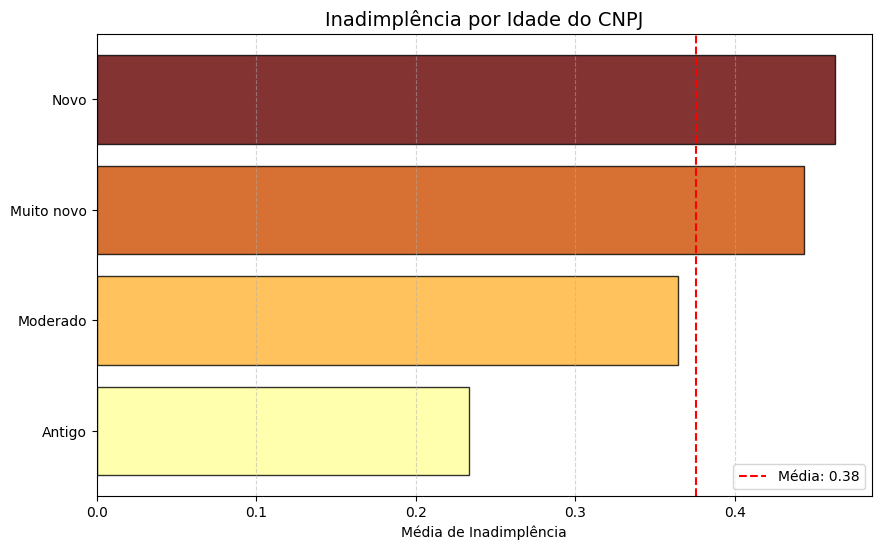

In [53]:
fig , ax = plt.subplots(1,figsize=(10, 6))

# categorias_legenda = {
#     "Muito novo": "≤ 1 ano",
#     "Novo": "≤ 4 anos",
#     "Moderado": "< 10 anos",
#     "Antigo": "≥ 10 anos"
# }

cnpj_grouped = df.groupby('cnpj_categoria').inadimplente.mean().sort_values()
colors = sns.color_palette('afmhot_r', 4)
bars = ax.barh(cnpj_grouped.index, cnpj_grouped, color=colors, edgecolor='black', alpha=0.8)
ax.axvline(cnpj_grouped.mean(), color='red', linestyle='--', label=f'Média: {cnpj_grouped.mean():.2f}')

ax.set_title('Inadimplência por Idade do CNPJ', fontsize=14)
ax.set_xlabel('Média de Inadimplência')
ax.grid(axis='x', linestyle='--', alpha=0.5)
ax.legend(loc='lower right')

plt.show()

# **Implementação dos Modelos**
# -----------------------------------
# *  CatBoost
# *  XGBoost
# *  Gradient Boosting (Sklearn)
# *  Regressão Logística (Sklearn)


---
### **Pré-processamento de Dados.**
---

In [112]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=["inadimplente"]),
    df["inadimplente"],
    test_size=0.20,
    stratify=df["inadimplente"],
    random_state=42
)


# Verificar tamanhos
print(f"Treino: {X_train.shape[0]} amostras")
print(f"Teste: {X_test.shape[0]} amostras")

Treino: 9966 amostras
Teste: 2492 amostras


In [113]:
#serasa_socio_tem_negativacao, has_ifood, has_google_maps
X_train.head()


,uf,segmento_cliente,natureza_juridica,fonte_cliente,cnae_descricao,capital_social,serasa_socio_tem_negativacao,has_ifood,has_google_maps,has_website,ifood_preco,cnpj_categoria,perfil_risco,deve_outra_empresa,numero_credores,cnae_divisao,categoria_municipio
3486,AL,Doces & Confeitaria,213-5 - Empresário (Individual),Fonte 5,Comércio varejista de outros produtos não espe...,14.095150,1,0,0,Nao tem Website,Não listado no iFood,Novo,Baixo,0,0,Comércio Varejista,Capital
2955,PE,Restaurante Brasileiro,213-5 - Empresário (Individual),Fonte 1,Fabricação de produtos de padaria e confeitari...,6.665336,1,0,0,Nao tem Website,Não listado no iFood,Novo,Baixo,0,0,Fabricação de Produtos Alimentícios,Região Metropolitana
9853,PE,Bar,213-5 - Empresário (Individual),Fonte 2,Fabricação de produtos de carne,9.231221,0,0,0,Nao tem Website,Não listado no iFood,Muito novo,Baixo,0,0,Fabricação de Produtos Alimentícios,Capital
3825,AL,Lanches & Salgados,213-5 - Empresário (Individual),Fonte 5,"Lanchonetes, casas de chá, de sucos e similares",13.135870,0,0,0,Nao tem Website,Não listado no iFood,Novo,Baixo,0,0,Alimentação,Capital
10408,PE,Distribuidor,213-5 - Empresário (Individual),Fonte 5,Restaurantes e similares,9.231221,1,0,0,Nao tem Website,Não listado no iFood,Novo,Baixo,0,0,Alimentação,Capital


In [114]:
# Definir colunas
numeric_features = ['capital_social', 'numero_credores']

cat_nominal = ['uf', 'fonte_cliente',
               'deve_outra_empresa', 'has_website',
               'cnpj_categoria', 'categoria_municipio']

cat_nominal_medium_cardinality = ['segmento_cliente', 'natureza_juridica']

cat_ordinal = ['perfil_risco', 'ifood_preco']

cat_nom_high_cardinality = ['cnae_divisao', 'cnae_descricao']



# Criar o ColumnTransformer para aplicar as transformações apropriadas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat_nom', OneHotEncoder(), cat_nominal),
        ('cat_ord', OrdinalEncoder(), cat_ordinal),
        ('cat_nom_medium', TargetEncoder(), cat_nominal_medium_cardinality + cat_nom_high_cardinality)
    ],    remainder='passthrough'
)


X_train_encoded = preprocessor.fit_transform(X_train, y_train)
X_test_encoded = preprocessor.fit_transform(X_test, y_test)

cat_features = cat_nominal + cat_ordinal + cat_nominal_medium_cardinality + cat_nom_high_cardinality


 ## **Avaliação de Modelos para Seleção com Validação Cruzada**

In [115]:
# Definindo as métricas que serão avaliadas
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'roc_auc': 'roc_auc'
}

# Configurando o StratifiedKFold com 5 folds
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [116]:
# Validação cruzada para o CatBoost
catboost = cross_validate(
    CatBoostClassifier(verbose=0, random_state=42, cat_features=cat_features, early_stopping_rounds=100),
    X_train,
    y_train,
    cv=kf,
    scoring=scoring,
    error_score='raise',
)

# Validação cruzada para o Gradient Boosting
gb = cross_validate(
    GradientBoostingClassifier(random_state=42),
    X_train_encoded,
    y_train,
    cv=kf,
    scoring=scoring,
    error_score='raise'
)

# Validação cruzada para o XGBoost
xgb_model = xgb.XGBClassifier(eval_metric='logloss', random_state=42)
xgboost = cross_validate(
    xgb_model,
    X_train_encoded,
    y_train,
    cv=kf,
    scoring=scoring,
    error_score='raise'
)

# Validação cruzada para a Regressão Logística
logreg_model = LogisticRegression(random_state=42, max_iter=1000)
logreg = cross_validate(
    logreg_model,
    X_train_encoded,
    y_train,
    cv=kf,
    scoring=scoring,
    error_score='raise'
)

# Gerando um DataFrame com os resultados
summary = pd.DataFrame({
    'labels': ['accuracy', 'precision', 'roc_auc'],
    'catboost': [
        catboost['test_accuracy'].mean(),
        catboost['test_precision'].mean(),
        catboost['test_roc_auc'].mean()
    ],
    'gb': [
        gb['test_accuracy'].mean(),
        gb['test_precision'].mean(),
        gb['test_roc_auc'].mean()
    ],
    'xgboost': [
        xgboost['test_accuracy'].mean(),
        xgboost['test_precision'].mean(),
        xgboost['test_roc_auc'].mean()
    ],
    'logreg': [
        logreg['test_accuracy'].mean(),
        logreg['test_precision'].mean(),
        logreg['test_roc_auc'].mean()
    ]
    }).set_index('labels')
summary.index.name = None


summary = summary.transpose()

In [129]:
summary_ordenado = summary.sort_values(by='roc_auc', ascending=False)

print(summary_ordenado)

          accuracy  precision   roc_auc
catboost  0.721454   0.679409  0.790227
gb        0.718243   0.680568  0.785594
logreg    0.708710   0.667461  0.772228
xgboost   0.700582   0.644606  0.763678


## **Escolha do Modelo: CatBoost e Ajuste de Hiperparâmetros**


In [118]:
def objective_catboost(trial):
    params = {
        # Controle de treinamento
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 20, 100),
        'iterations': trial.suggest_int('iterations', 500, 2000, step=50),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),

        # Estrutura da árvore
        'depth': trial.suggest_int('depth', 4, 12),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 100),

        # Regularização
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-5, 100, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-5, 10, log=True),

        # Pré-processamento
        'border_count': trial.suggest_int('border_count', 100, 255),
        'verbose': 0,
        'random_state': 42,
    }


    # Validação cruzada
    model = CatBoostClassifier(**params, cat_features=cat_features)

    scores = cross_validate(model, X_train, y_train, cv=kf, scoring=scoring, error_score='raise')

    return np.mean(scores['test_roc_auc'])



# Criar estudo e otimizar
study_catboost = optuna.create_study(direction='maximize')
study_catboost.optimize(objective_catboost, n_trials=25)

# Melhor conjunto de hiperparâmetros
print("Melhores hiperparâmetros para CatBoost:", study_catboost.best_params)


[I 2025-02-25 23:46:34,893] A new study created in memory with name: no-name-4b9f1d7d-1f01-4a30-a75f-d2e1e3cf0ee3
[I 2025-02-25 23:51:08,651] Trial 0 finished with value: 0.7857800389456507 and parameters: {'early_stopping_rounds': 60, 'iterations': 1750, 'learning_rate': 0.00950742075069677, 'depth': 11, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 65, 'l2_leaf_reg': 2.8593642300007325, 'random_strength': 2.6252137738999197e-05, 'border_count': 217}. Best is trial 0 with value: 0.7857800389456507.
[I 2025-02-25 23:52:39,090] Trial 1 finished with value: 0.773335647274387 and parameters: {'early_stopping_rounds': 53, 'iterations': 500, 'learning_rate': 0.028742658274579565, 'depth': 9, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 13, 'l2_leaf_reg': 0.006139423828845073, 'random_strength': 0.1481690501636988, 'border_count': 194}. Best is trial 0 with value: 0.7857800389456507.
[I 2025-02-25 23:58:04,363] Trial 2 finished with value: 0.7513997503689348 and parameters: {'early_stop

Melhores hiperparâmetros para CatBoost: {'early_stopping_rounds': 22, 'iterations': 1150, 'learning_rate': 0.022937926552577117, 'depth': 7, 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 57, 'l2_leaf_reg': 2.184769391451542, 'random_strength': 0.014019476862395736, 'border_count': 119}


In [124]:
best_params_catboost = study_catboost.best_params

final_cb = CatBoostClassifier(**best_params_catboost, random_state=42, verbose=0, cat_features=cat_features)

# Treinar no conjunto completo
final_cb.fit(X_train, y_train)

y_pred_cb = final_cb.predict_proba(X_test)[:, 1]
roc_auc_cb = roc_auc_score(y_test, y_pred_cb)

print(f"ROC AUC do CatBoost otimizado: {roc_auc_cb:.3f}")


ROC AUC do CatBoost otimizado: 0.803


## **Visualização da ROC Curve do Modelo**

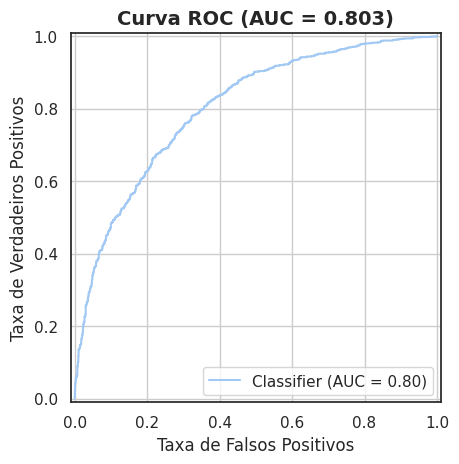

In [128]:
roc_display = RocCurveDisplay.from_predictions(y_test, y_pred_cb)
plt.title(f"Curva ROC (AUC = {roc_auc_cb:.3f})", fontsize=14, fontweight="bold")
plt.xlabel("Taxa de Falsos Positivos", fontsize=12)
plt.ylabel("Taxa de Verdadeiros Positivos", fontsize=12)
plt.grid(True)
plt.show()